# Understanding ARIMA 
--------------------------------------
- **Autoregressive** - a model that uses the dependent relationship between an observation and some number of lagged observations
- **Integrated** - The use of differencing of raw observations(like how the .rolling function works)
- **Moving Average** - a model that uses the dependency between an observation and a residual error from a moving average model    applied to logged observations


## Standard Notation ARIMA(p,d,q)

### Parameters
1. p - lag observations included in the model, realted to the autocorrelation function (ACF)
2. d - the degree of differencing, relationed to the stationarity of the data
3. q - the size of the moving average window, related to the partial autocorrelation function (PACF)


In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import os


In [3]:
cwd = os.getcwd()
df = pd.read_csv(os.path.join(cwd, 'dispo_timeseries.csv'))


In [4]:
df.drop('Unnamed: 0',axis=1, inplace=True)

In [5]:
dispo_series = df.groupby('time')['quantity'].sum()

In [6]:
dispo_series.head()

time
1    47.0
2    37.0
3    32.0
4    44.0
5    49.0
Name: quantity, dtype: float64

# Get an understanding of the data through descriptive stats and plotting


Text(0, 0.5, 'units sold')

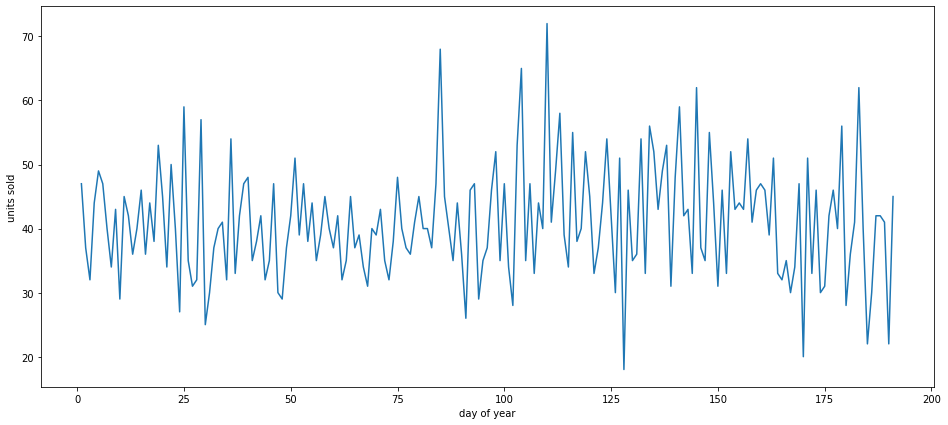

In [7]:
plt.figure(figsize=(16,7))
plt.plot(dispo_series)

plt.xlabel('day of year')
plt.ylabel('units sold')


In [8]:
dispo_series.describe( )

count    191.000000
mean      41.015707
std        8.899720
min       18.000000
25%       35.000000
50%       40.000000
75%       46.000000
max       72.000000
Name: quantity, dtype: float64

In [9]:
dispo_series.dropna(inplace=True)

# Checking for Stationarity
 Using rolling stats
  - Rolling Mean
  - Rolling Standard Dev


In [10]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.arima.model import ARIMA
from matplotlib.pylab import rcParams

## Creating Rolling Stats

In [11]:
roll_mean = dispo_series.rolling(window=7).mean()
roll_std = dispo_series.rolling(window=7).std()

In [12]:
print(roll_mean.isnull().value_counts())
print(roll_std.isnull().value_counts())


False    185
True       6
Name: quantity, dtype: int64
False    185
True       6
Name: quantity, dtype: int64


In [13]:
roll_mean.dropna(inplace=True)
roll_std.dropna(inplace=True)

In [14]:
print(roll_mean.isnull().value_counts())
print(roll_std.isnull().value_counts())


False    185
Name: quantity, dtype: int64
False    185
Name: quantity, dtype: int64


## Plotting Rolling Stats

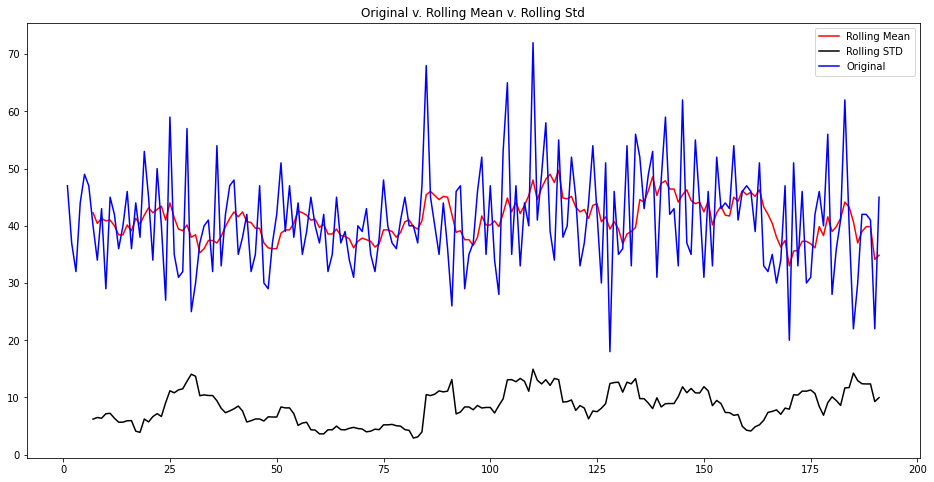

In [15]:
plt.figure(figsize=(16,8))
fig = plt.figure(1)


mean = plt.plot(roll_mean, color= 'red', label = 'Rolling Mean') 
std = plt.plot(roll_std, color = 'black', label= 'Rolling STD')
orig = plt.plot(dispo_series, color = 'blue', label= 'Original')

plt.title('Original v. Rolling Mean v. Rolling Std')
plt.legend(loc='best')
plt.show()

## The series is quite stationary. That is to say that there is no clear trend or cycle
## We can test this by running an Augmented Dickey Fuller Test

In this study we are going to focus on the ADF results of the test statistic relating to the critical values and the p-values

Ideally the p-value will be under 5%, or .05, or as close to zero as possible

-and-

the test statistic will not be greater than any critical value

--We can have a tolerance of p-value near .05 while test stat is within range of critical values

however, a p-value extremely close to 0 with a signigicantly lower (-4 or more) test value is great--



In [16]:
ADF_test= adfuller(dispo_series) #autolag defaultis aic

#adfuller() returns a tuple with a dictionary. Below is how I display the info

dickeyFuller_display = pd.Series(ADF_test[0:4], index=['Test Stat', 'p-value', 'Num of Lags Used', 'Num of Observation'])

for key, value in ADF_test[4].items():
    dickeyFuller_display['Crit Value (%s)' %key] = value


print('Dickey_Fuller Test Results:')
print(dickeyFuller_display)




Dickey_Fuller Test Results:
Test Stat            -1.523273e+01
p-value               5.293752e-28
Num of Lags Used      0.000000e+00
Num of Observation    1.900000e+02
Crit Value (1%)      -3.465244e+00
Crit Value (5%)      -2.876875e+00
Crit Value (10%)     -2.574945e+00
dtype: float64


## We have an incredibly low p-value and Test Statistic that is deep in the critical values. This is a stationary time series

## We will explore some transformations just in case


### Log scale transformation

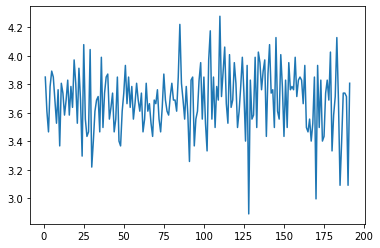

In [17]:
dispo_series_log = np.log(dispo_series)
plt.plot(dispo_series_log)

In [18]:
logged_ma = dispo_series_log.rolling(window=7).mean()


logged_ma.dropna(inplace=True)


In [19]:
logOG_minus_logMA = dispo_series_log - logged_ma
logOG_minus_logMA.dropna(inplace=True)
logOG_minus_logMA.isnull().value_counts()

False    185
Name: quantity, dtype: int64

### Exponential Decay Transformation
- using .ewm() ; Exponential Weighted Mean
- used on the log from above
- AKA Exponential Moving Average, for any stock traders out there

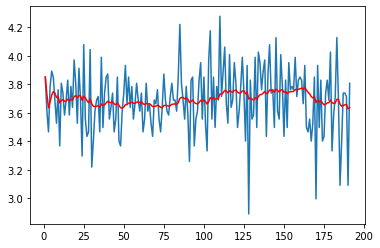

In [20]:
exp_decay_weighted_average = dispo_series_log.ewm(halflife=12, min_periods=0, adjust=True).mean()

plt.plot(dispo_series_log)
plt.plot(exp_decay_weighted_average, color= 'red')

### Lets use the same logic as the log_minus


In [21]:
log_minus_exp_decay = dispo_series_log - exp_decay_weighted_average


## Time Shift Tranforms

pandas function to shift index by desired number of period

- We will again use the log scale


In [22]:
dispo_series_log_shifted = dispo_series_log - dispo_series_log.shift()


# ---Function for stationarity test derived from above analysis---

In [23]:

 def stationarity_test(t_series):
     #create rolling statistics
    ma = t_series.rolling(window=7).mean()
    m_std = t_series.rolling(window=7).std()

    #Plotting Statistics
    plt.figure(figsize=(16,8))
    fig = plt.figure(1)

    mean = plt.plot(ma, color= 'red', label = 'Rolling Mean') 
    std = plt.plot(m_std, color = 'black', label= 'Rolling STD')
    orig = plt.plot(t_series, color = 'blue', label= 'Original')

    plt.title('Original v. Rolling Mean v. Rolling Std')
    plt.legend(loc='best')
    plt.show()

    ADF_test= adfuller(t_series) #autolag default is aic

    #adfuller() returns a tuple with a dictionary. Below is how I display the info

    dickeyFuller_display = pd.Series(ADF_test[0:4], index=['Test Stat', 'p-value', 'Num of Lags Used', 'Num of Observation'])

    for key, value in ADF_test[4].items():
        dickeyFuller_display['Crit Value (%s)' %key] = value


    print('Dickey_Fuller Test Results:')
    print(dickeyFuller_display)

# --Running Aug Dickey_fullers--

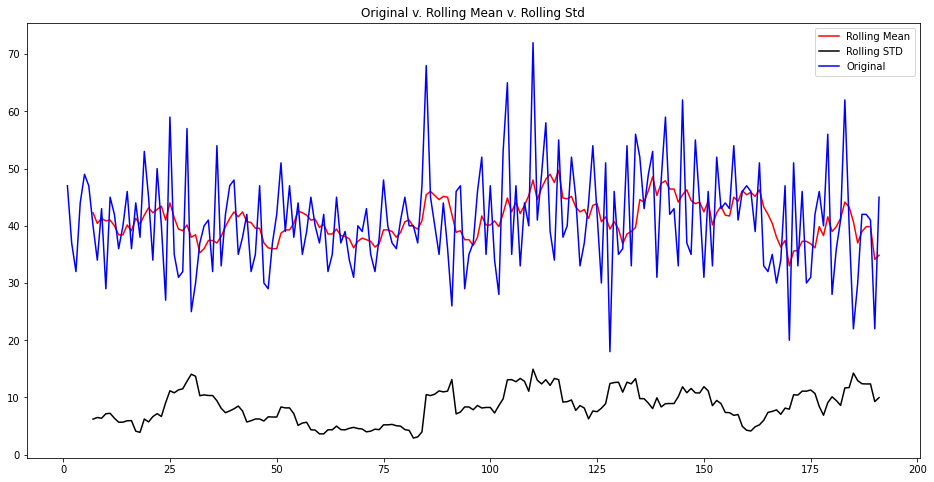

Dickey_Fuller Test Results:
Test Stat            -1.523273e+01
p-value               5.293752e-28
Num of Lags Used      0.000000e+00
Num of Observation    1.900000e+02
Crit Value (1%)      -3.465244e+00
Crit Value (5%)      -2.876875e+00
Crit Value (10%)     -2.574945e+00
dtype: float64


In [24]:
# Original Series
stationarity_test(dispo_series)

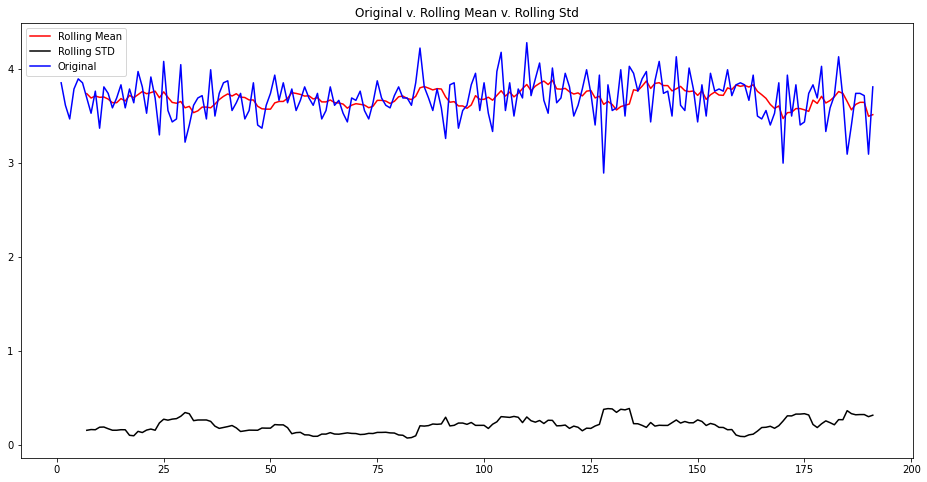

Dickey_Fuller Test Results:
Test Stat              -4.673998
p-value                 0.000094
Num of Lags Used        8.000000
Num of Observation    182.000000
Crit Value (1%)        -3.466800
Crit Value (5%)        -2.877555
Crit Value (10%)       -2.575308
dtype: float64


In [25]:
#Pure log on original Series
stationarity_test(dispo_series_log)

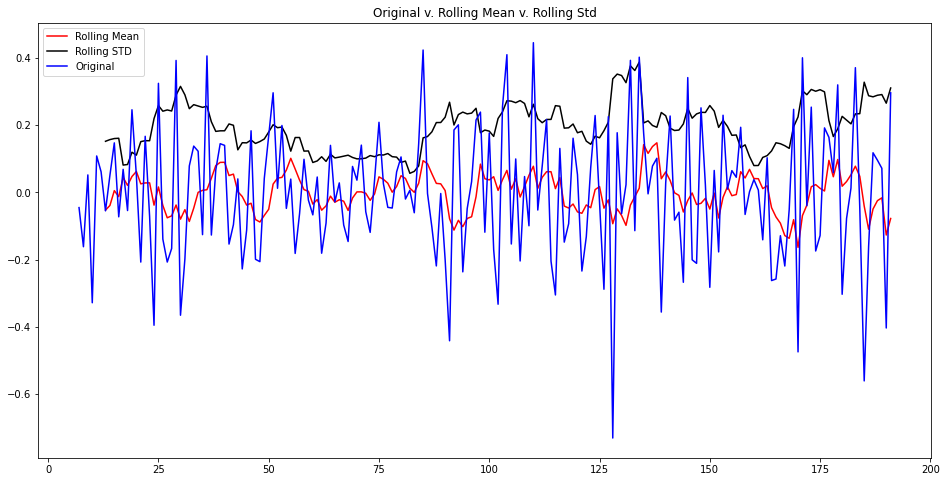

Dickey_Fuller Test Results:
Test Stat            -6.628457e+00
p-value               5.795737e-09
Num of Lags Used      8.000000e+00
Num of Observation    1.760000e+02
Crit Value (1%)      -3.468062e+00
Crit Value (5%)      -2.878106e+00
Crit Value (10%)     -2.575602e+00
dtype: float64


In [26]:
# log of original - log of moving average
stationarity_test(logOG_minus_logMA)

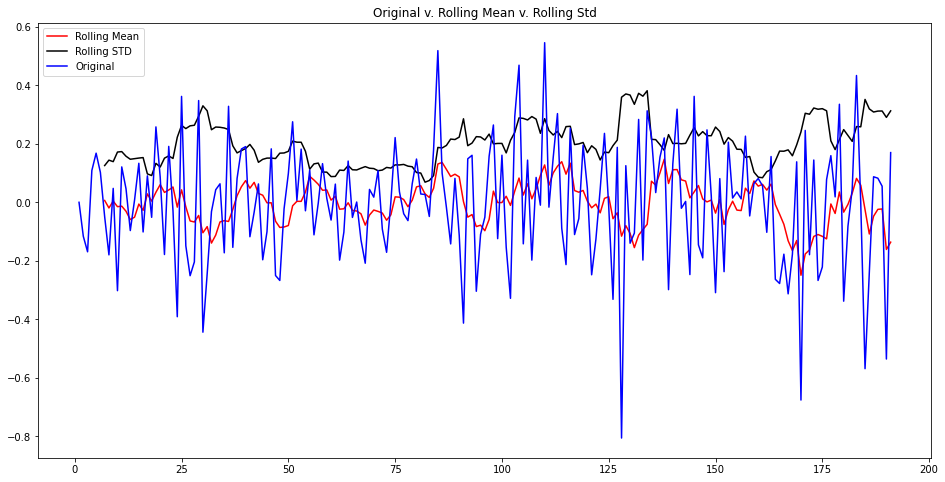

Dickey_Fuller Test Results:
Test Stat              -5.367127
p-value                 0.000004
Num of Lags Used        8.000000
Num of Observation    182.000000
Crit Value (1%)        -3.466800
Crit Value (5%)        -2.877555
Crit Value (10%)       -2.575308
dtype: float64


In [27]:
stationarity_test(log_minus_exp_decay)

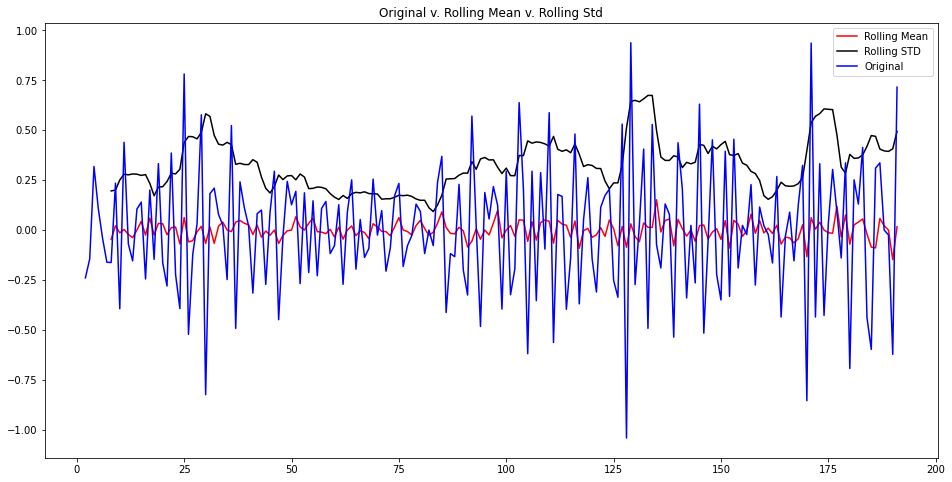

Dickey_Fuller Test Results:
Test Stat            -6.348285e+00
p-value               2.649412e-08
Num of Lags Used      1.300000e+01
Num of Observation    1.760000e+02
Crit Value (1%)      -3.468062e+00
Crit Value (5%)      -2.878106e+00
Crit Value (10%)     -2.575602e+00
dtype: float64


In [28]:
dispo_series_log_shifted.dropna(inplace=True)
stationarity_test(dispo_series_log_shifted)

# The original data set is ideal as shown from the methoda above
    - test stat is well within the critical values
    - p-test is under 5%, extremely low, in fact
    - used less than 10 lags

# Breaking it down though decomposition

## Decomposition

Your stationarity can be checked through Decomposition



In [29]:
#Insuring the Series index is in datetime format
#converted back to YYYY-dd-mm with arbitrary year
dispo_series.index = pd.to_datetime(dispo_series.index, format='%j')
dispo_series

time
1900-01-01    47.0
1900-01-02    37.0
1900-01-03    32.0
1900-01-04    44.0
1900-01-05    49.0
              ... 
1900-07-06    42.0
1900-07-07    42.0
1900-07-08    41.0
1900-07-09    22.0
1900-07-10    45.0
Name: quantity, Length: 191, dtype: float64

In [30]:
decomp = seasonal_decompose(dispo_series)

trend = decomp.trend
seasonal = decomp.seasonal
residual = decomp.resid


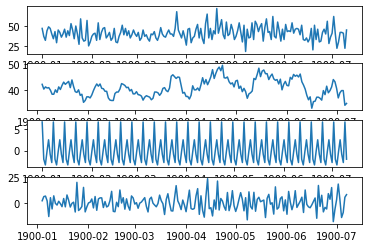

In [31]:
plt.subplot(411)
plt.plot(dispo_series, label= 'Original')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal')
plt.subplot(414)
plt.plot(residual, label= 'Residual')



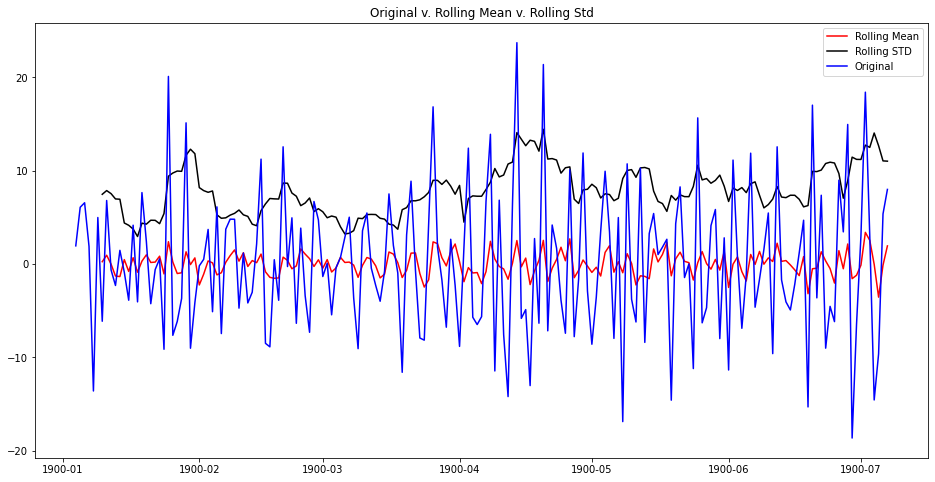

Dickey_Fuller Test Results:
Test Stat            -7.169574e+00
p-value               2.827533e-10
Num of Lags Used      1.300000e+01
Num of Observation    1.710000e+02
Crit Value (1%)      -3.469181e+00
Crit Value (5%)      -2.878595e+00
Crit Value (10%)     -2.575863e+00
dtype: float64


In [32]:
dispo_series_decomposed = residual
dispo_series_decomposed.dropna(inplace=True)

stationarity_test(dispo_series_decomposed)

# This is nice, but being that the lags we less on the original, I am going to stick with that

# To recap
## Stationarity helps with Differencing, aka d in arima parameters
## We want to test the [stationarity](https://machinelearningmastery.com/time-series-data-stationary-python/) of our time series, that is to say something with little pattern, cycles, or seasonality

## We can do this using an augmented Dickey_fuller test and satisfying a few criteria:
 - A test stat within the values of the critical values
 - A p-value close to zero, under 5% at least
 - The lowest number of lags

## If our orgininal data does not satisfy the above, we can find rolling stats such as Moving Average or Moving Standard Deviation

## Even further, we can transform the data using techniques such as:
- Log Scale transformation, where we also subtracted orig_log from MA_log
- Exponential Decay transformation
- Time Shift transformation
         These are expounded upon in this kaggle [notebook](https://www.kaggle.com/freespirit08/time-series-for-beginners-with-arima)
- Can also use the Log and Differencing method as referenced in this youtube [video](https://youtu.be/MVsKaYzEggY?t=367)

-----------------------------------------------------------------

   # Finding the order of p,q from AutoRegression Function(q), and Partial AutoRegression Function(p)

   ### We are looking to see where the line crosses to 0

   


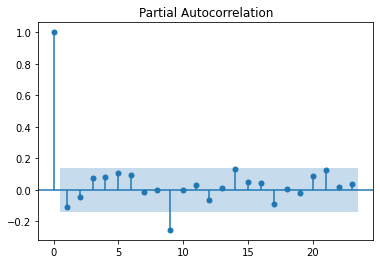

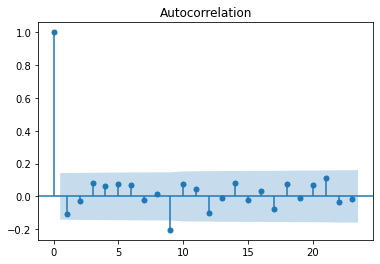

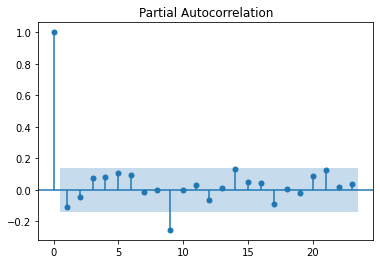

In [34]:
plot_acf(dispo_series_log)
plot_pacf(dispo_series_log)

### Both ACF and PACF for our q and p look to be 1 as a safe starting point

# The ARIMA Model

In [41]:
train=dispo_series[:120]
test=dispo_series[121:]
model = ARIMA(dispo_series, order=(0,1,0))
model_fit = model.fit()
predictions = pd.Series(model_fit.fittedvalues, copy=True)

C:\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


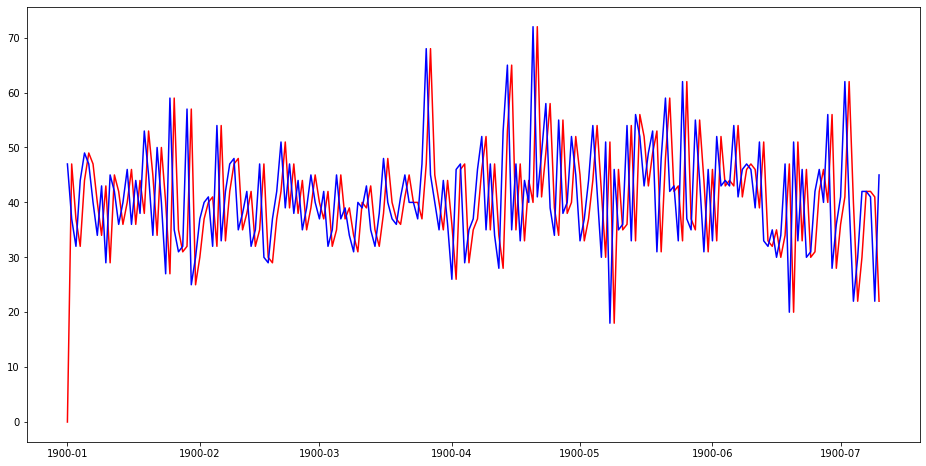

In [43]:
# Plot against original
plt.figure(figsize=(16,8))
plt.plot(predictions, color='red')
plt.plot(dispo_series, color='blue')

# Predictions

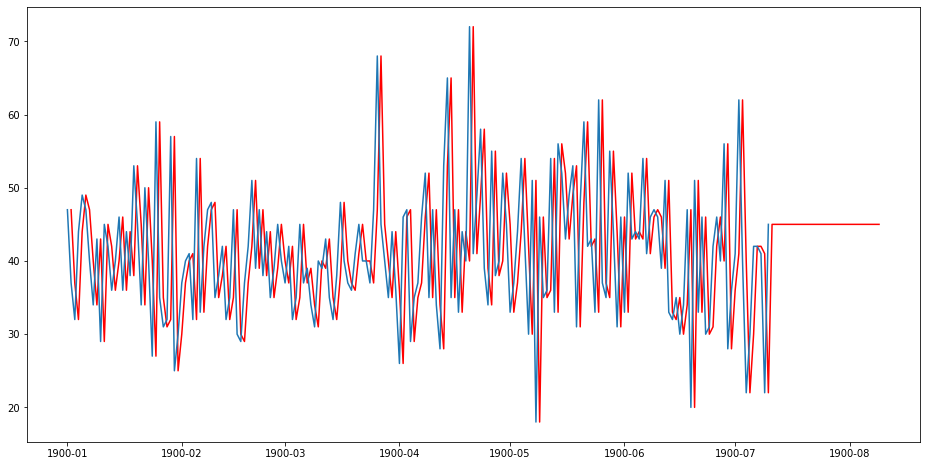

In [45]:
# Plotting Predictions
plt.figure(figsize=(16,8))
plt.plot(model_fit.predict(1,220), color='red')
plt.plot(dispo_series)

In [47]:
model_fit.predict(1,192).values

array([47., 37., 32., 44., 49., 47., 40., 34., 43., 29., 45., 42., 36.,
       40., 46., 36., 44., 38., 53., 45., 34., 50., 40., 27., 59., 35.,
       31., 32., 57., 25., 30., 37., 40., 41., 32., 54., 33., 42., 47.,
       48., 35., 38., 42., 32., 35., 47., 30., 29., 37., 42., 51., 39.,
       47., 38., 44., 35., 39., 45., 40., 37., 42., 32., 35., 45., 37.,
       39., 34., 31., 40., 39., 43., 35., 32., 38., 48., 40., 37., 36.,
       41., 45., 40., 40., 37., 47., 68., 45., 40., 35., 44., 36., 26.,
       46., 47., 29., 35., 37., 46., 52., 35., 47., 34., 28., 53., 65.,
       35., 47., 33., 44., 40., 72., 41., 49., 58., 39., 34., 55., 38.,
       40., 52., 45., 33., 37., 44., 54., 42., 30., 51., 18., 46., 35.,
       36., 54., 33., 56., 52., 43., 49., 53., 31., 48., 59., 42., 43.,
       33., 62., 37., 35., 55., 44., 31., 46., 33., 52., 43., 44., 43.,
       54., 41., 46., 47., 46., 39., 51., 33., 32., 35., 30., 34., 47.,
       20., 51., 33., 46., 30., 31., 42., 46., 40., 56., 28., 36

# Model flattens its predicitions immediately at 45

In [68]:
train=dispo_series[:120]
test=dispo_series[121:]
model_train = ARIMA(train, order=(0,1,0))
train_fit = model.fit()
predictions_train = pd.Series(train_fit.fittedvalues, copy=True)

C:\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


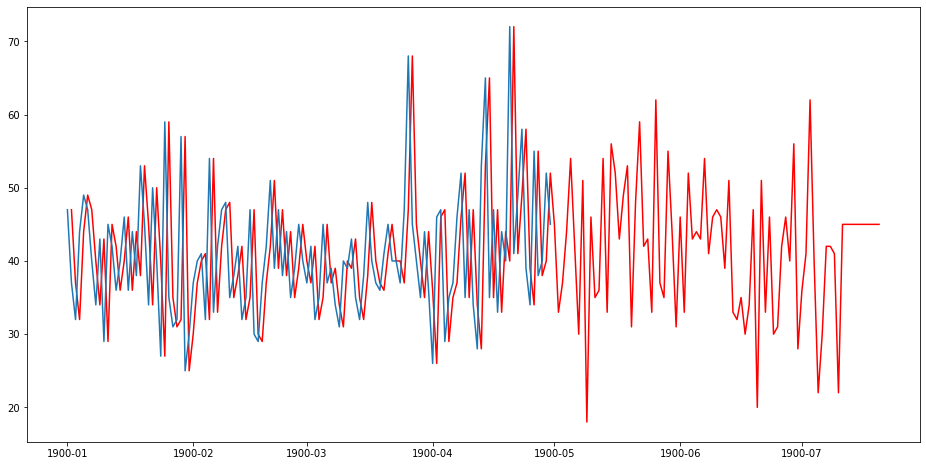

In [75]:
# Plotting Predictions
plt.figure(figsize=(16,8))
plt.plot(train_fit.predict(1,200), color='red')
plt.plot(train)

In [78]:
predict_series = pd.Series(train_fit.predict(1,200))

In [80]:
predict_series.tail(20)

1900-07-01    36.0
1900-07-02    41.0
1900-07-03    62.0
1900-07-04    40.0
1900-07-05    22.0
1900-07-06    30.0
1900-07-07    42.0
1900-07-08    42.0
1900-07-09    41.0
1900-07-10    22.0
1900-07-11    45.0
1900-07-12    45.0
1900-07-13    45.0
1900-07-14    45.0
1900-07-15    45.0
1900-07-16    45.0
1900-07-17    45.0
1900-07-18    45.0
1900-07-19    45.0
1900-07-20    45.0
Freq: D, Name: predicted_mean, dtype: float64